In [48]:
import osmnx as ox
import math
import heapq

## OSMNX for getting road network
Allows for us to get coordinates and network of any location specified to use for pathfinding algorithms.

In [50]:
# Get the graph for the area 
G = ox.graph_from_place("Manhattan, New York, USA", network_type="drive")
#Save the graph to a file
#ox.save_graphml(G, filepath="manhattan.graphml")

## Get Loaded Graph

In [51]:
G = ox.load_graphml("./data/manhattan_drive.graphml")


In [54]:
from opencage.geocoder import OpenCageGeocode
api_key = 'b691284543b641248480ea652bbff899'
geocoder = OpenCageGeocode(api_key)
def get_coordinates(place_name):
    # Use OpenCage for geocoding
    result = geocoder.geocode(place_name)
    if result and len(result):
        return (result[0]['geometry']['lat'], result[0]['geometry']['lng'])
    else:
        raise ValueError(f"Could not geocode location: {place_name}")

# Define your locations by name
start_location = "Empire State Building, New York, NY"
end_location = "Times Square, New York, NY"

# Get coordinates for each location
start_coords = get_coordinates(start_location)
end_coords = get_coordinates(end_location)

# Find the nearest nodes in the graph to these coordinates
start = ox.distance.nearest_nodes(G, X=start_coords[1], Y=start_coords[0])
goal = ox.distance.nearest_nodes(G, X=end_coords[1], Y=end_coords[0])

print(f"Start node: {start}")
print(f"Goal node: {goal}")

Start node: 42446701
Goal node: 42439984


## Convert graph to adjacency list

In [36]:
# Convert the graph to an adjacency list with distances
graph = {}
for node in G.nodes:
    graph[node] = {}
    for neighbor in G.adj[node]:
        edge_data = G.edges[node, neighbor, 0]  # Edge data (with `length` attribute)
        graph[node][neighbor] = edge_data['length']  # Distance between nodes
#print graph
print(graph)

{42421728: {42435337: 85.345, 42421731: 138.03300000000002, 42432736: 86.27499999999999}, 42421731: {42437916: 86.149, 42432737: 85.96799999999999, 42421728: 138.033, 42421737: 134.77100000000002}, 42421737: {42421731: 134.77100000000002, 42437917: 85.99, 42421741: 271.351}, 42421741: {42432756: 86.24000000000001, 1061531654: 199.79500000000002, 42421737: 271.351}, 42421745: {1061531654: 22.088, 42421749: 55.92400000000001, 11803957852: 93.53800000000001}, 42421749: {42421751: 142.26, 42421745: 55.924, 42431118: 85.52099999999999}, 42421751: {42421749: 142.26000000000002, 42432764: 85.181}, 42421769: {42443347: 86.01}, 42421772: {42421769: 271.70200000000006, 42442469: 81.618}, 42421775: {11655721345: 19.292, 42428653: 86.20899999999999}, 42421776: {42421775: 105.43299999999999, 42431024: 80.922, 42431019: 86.554}, 42421778: {42421776: 127.99200000000002, 42422592: 87.48, 42441587: 82.185}, 42421783: {42443522: 267.007, 42427782: 249.00000000000003, 42429174: 153.183, 8904913030: 29.60

In [37]:
# Euclidean distance as the heuristic function
def heuristic(node1, node2):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def a_star(graph, start, goal):
    # Priority queue for A*
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    # Track the cost of reaching each node
    g_cost = {node: float('inf') for node in graph}
    g_cost[start] = 0
    
    # Track the total estimated cost to reach the goal
    f_cost = {node: float('inf') for node in graph}
    f_cost[start] = heuristic(start, goal)
    
    # Store the path
    came_from = {}
    
    while open_set:
        # Get the node with the lowest f_cost
        _, current = heapq.heappop(open_set)
        
        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Return reversed path
        
        for neighbor, distance in graph[current].items():
            tentative_g_cost = g_cost[current] + distance
            
            if tentative_g_cost < g_cost[neighbor]:
                # Update path
                came_from[neighbor] = current
                g_cost[neighbor] = tentative_g_cost
                f_cost[neighbor] = tentative_g_cost + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_cost[neighbor], neighbor))
                
    return None  # If there's no path

In [38]:
def dijkstra(graph, start, goal):
    # Priority queue for Dijkstra's
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    # Track the cost of reaching each node
    g_cost = {node: float('inf') for node in graph}
    g_cost[start] = 0
    
    # Store the path
    came_from = {}
    
    while open_set:
        current_cost, current = heapq.heappop(open_set)
        
        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Return reversed path
        
        for neighbor, distance in graph[current].items():
            tentative_g_cost = current_cost + distance
            
            if tentative_g_cost < g_cost[neighbor]:
                # Update path
                came_from[neighbor] = current
                g_cost[neighbor] = tentative_g_cost
                heapq.heappush(open_set, (tentative_g_cost, neighbor))
                
    return None  # If there's no path

[42421728, 42435337, 42435336, 7801840675, 42435333, 42435331, 42425570, 42425232, 42424439, 42435328, 42435323, 42435319, 42435317, 42435316, 42431447, 42421993, 7106818627, 7106818623, 7106818626, 42424851, 42421800, 42435308, 42433564, 42427915, 42424225, 42435301, 42435295, 42435283, 42432556, 42435275, 42435272, 7802856356, 7802856372, 7802856349, 7802856341, 7802856352, 7802856365, 42435257, 42435253, 5706568625, 1061531509, 42428575, 42421972, 42428570, 1825841655, 1825841704, 1825841743, 42428332, 42428329, 42428328, 42428321, 42428315, 42428313, 42428312, 42428310, 42428308, 42428307, 42428305, 42439996, 42439994, 42439990, 42428297, 42439984, 42439981, 42437363, 42439972, 42439968, 42439964, 42433611, 42439960, 42439955, 42439952, 42437654, 4461990857, 42439440, 42435422, 42435420, 42427805, 42438547, 42434807, 42439842, 42439840, 42427426, 42437890, 42434270, 42439836, 42427374, 42439834, 42429661, 42439275, 42439830, 42439826, 42439823, 42429375, 42439073, 42430828, 1106271

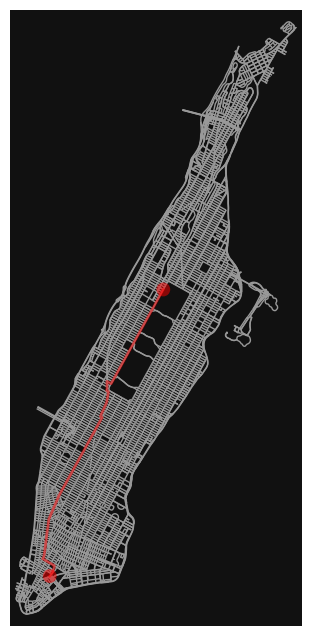

path [42421728, 42435337, 42435336, 7801840675, 42435333, 42435331, 42425570, 42425232, 42424439, 42435328, 42435323, 42435319, 42435317, 42435316, 42431447, 42421993, 7106818627, 7106818623, 7106818626, 42424851, 42421800, 42435308, 42433564, 42427915, 42424225, 42435301, 42435295, 42435283, 42432556, 42435275, 42435272, 7802856356, 7802856372, 7802856349, 7802856341, 7802856352, 7802856365, 42435257, 42435253, 5706568625, 1061531509, 42428575, 42421972, 42428570, 1825841655, 1825841704, 1825841743, 42428332, 42428329, 42428328, 42428321, 42428315, 42428313, 42428312, 42428310, 42428308, 42428307, 42428305, 42439996, 42439994, 42439990, 42428297, 42439984, 42439981, 42437363, 42439972, 42439968, 42439964, 42433611, 42439960, 42439955, 42439952, 42437654, 4461990857, 42439440, 42435422, 42435420, 42427805, 42438547, 42434807, 42439842, 42439840, 42427426, 42437890, 42434270, 42439836, 42427374, 42439834, 42429661, 42439275, 42439830, 42439826, 42439823, 42429375, 42439073, 42430828, 11

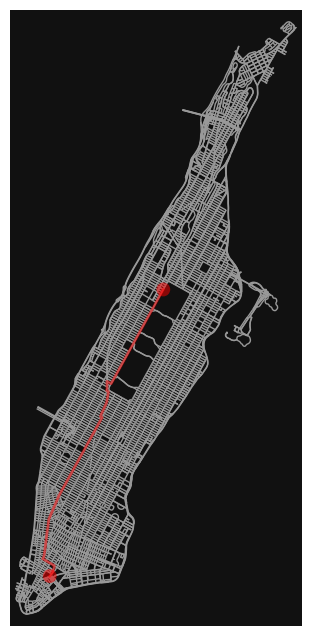

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [39]:
start = list(G.nodes())[0]
goal = list(G.nodes())[-1]
astar_path = a_star(graph, start, goal)
print(astar_path)
print("A* astar_path length:", sum(graph[astar_path[i]][astar_path[i + 1]] for i in range(len(astar_path) - 1)))
ox.plot_graph_route(G, astar_path, route_linewidth=2, node_size=0)

dijkstra_path = dijkstra(graph, start, goal)
print("path", dijkstra_path)
print("Dijkstra path length:", sum(graph[dijkstra_path[i]][dijkstra_path[i + 1]] for i in range(len(dijkstra_path) - 1)))
ox.plot_graph_route(G, dijkstra_path, route_linewidth=2, node_size=0)




## Create Py file for github team

SyntaxError: invalid syntax (3631835858.py, line 1)